In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ase
import hickle
import matplotlib.pyplot as plt
import metatensor
import numpy as np
import torch
from ase.io import read
from metatensor import Labels, TensorBlock, TensorMap
from rascaline import SphericalExpansion
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split

import mlelec.metrics as mlmetrics
from mlelec.features.acdc_utils import acdc_standardize_keys, cg_increment
from mlelec.utils.symmetry import ClebschGordanReal, spherical_to_xyz, xyz_to_spherical

In [3]:
polarisability = hickle.load('examples/data/qm7/sto-3g/polarisability.hickle')
polarisability = polarisability.astype(np.float64)

In [4]:
block = TensorBlock(
values = polarisability.reshape(-1,3,3,1),
samples = metatensor.Labels.range('structure', polarisability.shape[0]),
components = [metatensor.Labels.range('component_1', 3),metatensor.Labels.range('component_2', 3)],
properties = metatensor.Labels.range('value', 1)
)

In [5]:
li = 1
lj = 1
cg = ClebschGordanReal(4)

decoupled = torch.moveaxis(torch.from_numpy(block.values), -1, -2).reshape(
            (len(block.samples), len(block.properties), 2 * li + 1, 2 * lj + 1)
        )

coupled = cg.couple(torch.from_numpy(xyz_to_spherical(decoupled)))[(li, lj)]

In [6]:
block1 = TensorBlock(
    values = coupled[0].reshape(-1,1,1),
    samples= metatensor.Labels.range('structure',len(polarisability)),
    components= [metatensor.Labels.range('alpha',1)], 
    properties=metatensor.Labels.range('value',1)  
)
block2 = TensorBlock(
    values = coupled[2].reshape(-1,5,1),
    samples= metatensor.Labels.range('structure',len(polarisability)),
    components= [metatensor.Labels.range('alpha',5)], 
    properties=metatensor.Labels.range('value',1)  
)
keys = Labels(names=["lambda"], values=np.array([[0], [2]]))

alpha_mts = TensorMap(keys, [block1, block2])

In [7]:
frames = read("examples/data/qm7/qm7.xyz", ":1000")

In [8]:
hypers = {
        "cutoff": 3.0,
        "max_radial" : 6,
        "max_angular": 4,
        "atomic_gaussian_width": 0.3,
        "center_atom_weight": 1,
        "radial_basis": {"Gto": {}},
        "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
    }


calculator = SphericalExpansion(**hypers)
rhoi = calculator.compute(frames, use_native_system=True)
rhoi = rhoi.keys_to_properties(["species_neighbor"])
rho1i = acdc_standardize_keys(rhoi)

In [9]:
from mlelec.utils.symmetry import ClebschGordanReal
cg = ClebschGordanReal(4)

In [10]:
rho2i = cg_increment(
    rho1i,
    rho1i,
    cg,
    2,
    other_keys_match=["species_center"],
)

In [11]:
rho2i = metatensor.remove_dimension(rho2i, axis="keys", name="order_nu")

In [12]:
for i,b in rho2i.items():
    if i[1] == 1:
        rho2i = metatensor.drop_blocks(rho2i, Labels(i.names, i.values.reshape(1,-1)))

In [13]:
lsoap = rho2i.keys_to_samples(["species_center"])

In [14]:
feats = metatensor.sum_over_samples(lsoap, ['center', 'species_center'])

In [15]:
X_0 = feats[0].values
y_0 = alpha_mts[0].values

X_2 = feats[1].values
y_2 = alpha_mts[1].values

In [16]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_0, y_0, range(len(X_0)), test_size=0.2, random_state=1234)
X_train2, X_test2, y_train2, y_test2, train_indices2, test_indices2 = train_test_split(X_2, y_2, range(len(X_2)), test_size=0.2, random_state=1234)

### Testing on QM9

In [17]:
polarisability_qm9 = hickle.load('examples/data/qm9/sto-3g/polarisability.hickle')
polarisability_qm9 = polarisability_qm9.astype(np.float64)

In [18]:
decoup = polarisability_qm9.reshape(-1,1,3,3)

coup = cg.couple(torch.from_numpy(xyz_to_spherical(decoup)))[(li, lj)]

In [19]:
block1 = TensorBlock(
    values = coup[0].reshape(-1,1,1),
    samples= metatensor.Labels.range('structure',len(polarisability_qm9)),
    components= [metatensor.Labels.range('alpha',1)], 
    properties=metatensor.Labels.range('value',1)  
)
block2 = TensorBlock(
    values = coup[2].reshape(-1,5,1),
    samples= metatensor.Labels.range('structure',len(polarisability_qm9)),
    components= [metatensor.Labels.range('alpha',5)], 
    properties=metatensor.Labels.range('value',1)  
)
keys = Labels(names=["lambda"], values=np.array([[0], [2]]))

alpha_qm9_mts = TensorMap(keys, [block1, block2])

In [20]:
frames_qm9 = read("examples/data/qm9/qm9.xyz", ":")

In [21]:
rhoi_qm9 = calculator.compute(frames_qm9, use_native_system=True)
rhoi_qm9 = rhoi_qm9.keys_to_properties(["species_neighbor"])
rho1i_qm9 = acdc_standardize_keys(rhoi_qm9)

In [22]:
rho2i_qm9 = cg_increment(
    rho1i_qm9,
    rho1i_qm9,
    cg,
    2,
    other_keys_match=["species_center"],
)

In [23]:
rho2i_qm9 = metatensor.remove_dimension(rho2i_qm9, axis="keys", name="order_nu")

In [24]:
for i,b in rho2i_qm9.items():
    if i[1] == 1:
        rho2i_qm9 = metatensor.drop_blocks(rho2i_qm9, Labels(i.names, i.values.reshape(1,-1)))

In [25]:
lsoap_qm9 = rho2i_qm9.keys_to_samples(["species_center"])

In [26]:
feats_qm9 = metatensor.sum_over_samples(lsoap_qm9, ['center', 'species_center'])

In [27]:
X_0_qm9 = feats_qm9[0].values
y_0_qm9 = alpha_qm9_mts[0].values

X_2_qm9 = feats_qm9[1].values
y_2_qm9 = alpha_qm9_mts[1].values

In [28]:
train_idx = [5, 10, 50, 100, 200, 400, 800]
rmse_0 = []
rmse_2 = []
rmse_full = []
rmse_qm9_0 = []
rmse_qm9_2 = []
rmse_qm9_full = []
for ntrain in train_idx:

    # training for lamda=0 component
    ridge_0 = RidgeCV(alphas=np.logspace(-8, 3, 12), fit_intercept=True)
    ridge_0.fit(X_train[:ntrain].reshape(-1, X_train.shape[2]), y_train[:ntrain].reshape(-1, y_train.shape[2]))
    y_pred = ridge_0.predict(X_test.reshape(-1, X_test.shape[2]))
    y_pred = y_pred.reshape(-1,1,1)
    y_pred_qm9 = ridge_0.predict(X_0_qm9.reshape(-1, X_0_qm9.shape[2]))
    y_pred_qm9 = y_pred_qm9.reshape(-1,1,1)
    test_mse = mlmetrics.mse_qm7([frames[i] for i in test_indices], torch.from_numpy(y_pred), y_test)
    test_mse_qm9 = mlmetrics.mse_qm7(frames_qm9, torch.from_numpy(y_pred_qm9), y_0_qm9)
    rmse_0.append(torch.sqrt(test_mse))
    rmse_qm9_0.append(torch.sqrt(test_mse_qm9))

    # training for lamda=2 component
    ridge_2 = RidgeCV(alphas=np.logspace(-8, 3, 12), cv=3, fit_intercept=False)
    ridge_2.fit(X_train2[:ntrain].reshape(-1, X_train2.shape[2]), y_train2[:ntrain].reshape(-1, y_train2.shape[2]))
    y_pred_2 = ridge_2.predict(X_test2.reshape(-1, X_test2.shape[2]))
    y_pred_2 = y_pred_2.reshape(-1,5,1)
    test_mse2 = mlmetrics.mse_qm7([frames[i] for i in test_indices2], torch.from_numpy(y_pred_2), y_test2)
    rmse_2.append(torch.sqrt(test_mse2))
    y_pred_2_qm9 = ridge_2.predict(X_2_qm9.reshape(-1, X_2_qm9.shape[2]))
    y_pred_2_qm9 = y_pred_2_qm9.reshape(-1,5,1)
    test_mse2_qm9 = mlmetrics.mse_qm7(frames_qm9, torch.from_numpy(y_pred_2_qm9), y_2_qm9)
    rmse_qm9_2.append(torch.sqrt(test_mse2_qm9))

    # error on the full matrix
    pred_coupled = {}
    pred_coupled[0] = y_pred
    pred_coupled[2] = y_pred_2.reshape(-1,1,5)
    pred_polar = cg.decouple({(li, lj): pred_coupled})
    polar_mse = mlmetrics.mse_qm7([frames[i] for i in test_indices], torch.from_numpy(polarisability[test_indices]), spherical_to_xyz(pred_polar).reshape(-1,3,3))
    rmse_full.append(torch.sqrt(polar_mse))

    pred_coupled_qm9 = {}
    pred_coupled_qm9[0] = y_pred_qm9
    pred_coupled_qm9[2] = y_pred_2_qm9.reshape(-1,1,5)
    pred_polar_qm9 = cg.decouple({(li, lj): pred_coupled_qm9})
    polar_mse_qm9 = mlmetrics.mse_qm7(frames_qm9, torch.from_numpy(polarisability_qm9), spherical_to_xyz(pred_polar_qm9).reshape(-1,3,3))
    rmse_qm9_full.append(torch.sqrt(polar_mse_qm9))

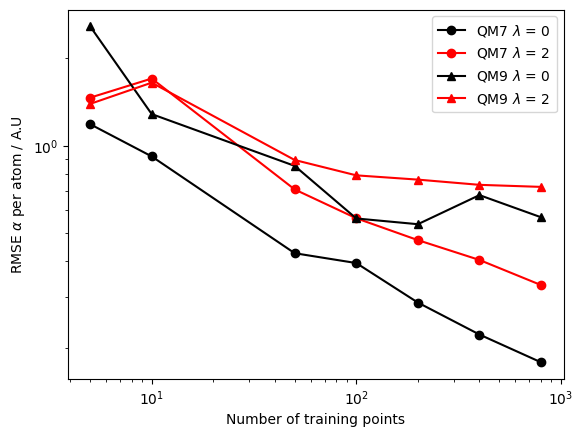

In [29]:
plt.figure()
plt.loglog(train_idx, rmse_0, marker='o', color='k', label=r"QM7 $\lambda$ = 0")
plt.loglog(train_idx, rmse_2, marker='o', color='r', label=r"QM7 $\lambda$ = 2")
plt.loglog(train_idx, rmse_qm9_0, marker='^', color='k', label=r"QM9 $\lambda$ = 0")
plt.loglog(train_idx, rmse_qm9_2, marker='^', color='r', label=r"QM9 $\lambda$ = 2")
plt.xlabel('Number of training points')
plt.ylabel(r'RMSE $\alpha$ per atom / A.U')
plt.legend()

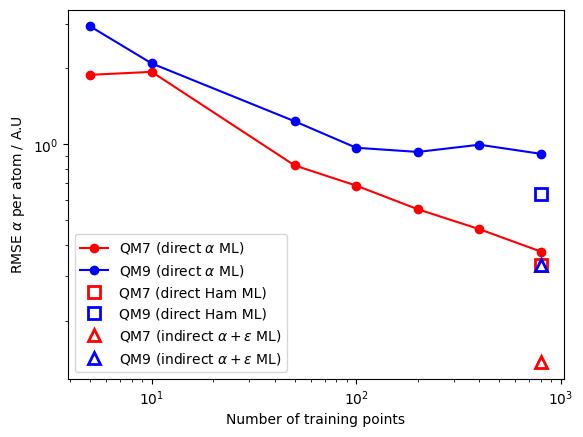

In [30]:
plt.figure()
plt.loglog(train_idx, rmse_full, marker='o', color='r', label=r"QM7 (direct $\alpha$ ML)")
plt.loglog(train_idx, rmse_qm9_full, marker='o', color='b', label=r"QM9 (direct $\alpha$ ML)")

plt.loglog([800], [0.3335], marker='s', markersize=8, markeredgewidth=2, markeredgecolor='red', color='white', label="QM7 (direct Ham ML)")
plt.loglog([800], [0.6337], marker='s', markersize=8, markeredgewidth=2, markeredgecolor='blue', color='white', label="QM9 (direct Ham ML)")
plt.loglog([800], [0.1367], marker='^', markersize=8, markeredgewidth=2, markeredgecolor='red', color='white', label=r"QM7 (indirect $\alpha + \epsilon$ ML)")
plt.loglog([800], [0.3319], marker='^', markersize=8, markeredgewidth=2, markeredgecolor='blue', color='white', label=r"QM9 (indirect $\alpha + \epsilon$ ML)")

plt.xlabel('Number of training points')
plt.ylabel(r'RMSE $\alpha$ per atom / A.U')
plt.legend()
plt.savefig("polar_rmse_comparison.pdf", bbox_inches='tight')